In [1]:
import torch
import numpy as np
import random
import torch.optim as optim
from model import *
from algorithms import *
from dataset import *
from utils import *
from tabulate import tabulate
from matplotlib import pyplot as plt
import csv
import os

### Fit ground-truth model h

- Improvable: 1,2

In [2]:
device = 'cpu'
data = IncomeDataset(device = device)
imp_features = [1,2]
data.X_train_.columns[imp_features]

Index(['SCHL', 'WKHP'], dtype='object')

In [3]:
# change ctv in this block
ctv = torch.zeros(4)
ctv[imp_features] = 1
print(ctv)

# train model is too time consuming
model_path = 'h_models/h_income.pth'
if os.path.exists(model_path):
    print('h found, load h')
    h = MLP(4,[10,10,10])
    h.load_state_dict(torch.load('h_models/h_income.pth'))

else:
    print('train h')
    test_acc = 0
    for i in range(7):
        np.random.seed(i)
        torch.manual_seed(i)
        random.seed(i)
        h = MLP(4,[10,10,10])
        optimizer = optim.Adam(h.parameters(), lr=0.05, weight_decay=1e-4)
        device = 'cpu'
        batch_size = 1024
        n_epochs = 10
        test_acc += 1/7*trainer_h(h, data, optimizer, device, n_epochs, batch_size)
    
    print(f'average model testng accuracy is {test_acc:4.2f}% ')     
    torch.save(h.state_dict(), 'h_models/h_income.pth')

tensor([0., 1., 1., 0.])
h found, load h


### Hyper parameters selection: Logistic


In [4]:
def log_model_runner(dataset, hp, seeds, mode='baseline'):
    train, val, test = generate_res()

    for i in range(len(seeds)):
        print('training seed', seeds[i] ,'started')
        random.seed(seeds[i])
        np.random.seed(seeds[i])
        torch.manual_seed(seeds[i]) 

        model = logReg(dataset.XZ_train.shape[1])
        model = model.to(device)
        
        lr = hp['learning_rate']
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        
        if mode == 'baseline':
            results = trainer_baselines(
                model,
                h,
                dataset,
                optimizer,
                device,
                n_epochs=hp['n_epochs'],
                batch_size=hp['batch_size'], 
                z_blind=False,
                metric=hp['metric'], 
                lambda_=hp['lambda_'],
                delta_effort=hp['delta_effort'],
                ctv = ctv
            )


        else:
            results = trainer_new(
                model,
                h,
                dataset,
                optimizer,
                device,
                n_epochs=hp['n_epochs'],
                batch_size=hp['batch_size'], 
                z_blind=False,
                delta_effort=hp['delta_effort'],
                lambda2_ = hp['lambda2'],
                lambda3_ = hp['lambda3'],
                ctv = ctv,
                add_safe = hp['add_safe']
            )      
        
        append_res(train,results.train_imp_all[-1],results.train_imp_a[-1], results.train_imp_b[-1], results.train_safety[-1],results.train_aw_a[-1], results.train_aw_b[-1],results.train_aw_all[-1],results.train_acc_hist[-1],results.train_ei_hist[-1],results.train_be_hist[-1],results.train_dp_hist[-1],results.train_eo_hist[-1],results.train_eodd_hist[-1])
        append_res(val,results.val_imp_all,results.val_imp_a, results.val_imp_b, results.val_safety, results.val_aw_a, results.val_aw_b, results.val_aw_all,results.val_acc, results.val_ei,results.val_be,results.val_dp,results.val_eo,results.val_eodd)
        append_res(test,results.test_imp_all,results.test_imp_a, results.test_imp_b, results.test_safety, results.test_aw_a, results.test_aw_b, results.test_aw_all, results.test_acc,results.test_ei,results.test_be,results.test_dp,results.test_eo,results.test_eodd)

    res_train = get_res(train)
    res_val = get_res(val)
    res_test = get_res(test)
    print('Training finished for all seeds.')
    
    return res_train, res_val, res_test



def log_hyperparameter_test_imp(dataset, hp_test, seed=[0], mode='new'):
    hp = hp_test.copy()
    result = []
    for i in hp_test['learning_rate']:
        for k in hp_test['lambda2']:
            for j in hp_test['lambda3']:
                c = []
                hp['learning_rate'] = i
                hp['lambda2'] = k
                hp['lambda3'] = j
                train, val, _ = log_model_runner(dataset, hp, seeds=seed, mode=mode)
                c.append(hp['learning_rate'])
                c.append(hp['lambda2'])
                c.append(hp['lambda3'])
                c.append(train['accuracy_mean'])
                c.append(val['accuracy_mean'])
                c.append(val['imp_all_mean'])
                c.append(val['safety_mean'])
                c.append(val['swf_mean'])
                c.append(val['aw_all_mean'])
                c.append(val['ei_mean'])
                c.append(val['be_mean'])
                c.append(val['dp_mean'])
                c.append(val['eo_mean'])
                c.append(val['eodd_mean'])
                result.append(c)
    print(tabulate(result, headers=['learning_rate', 'lambda2_', 'lambda3_','accuracy_train', 'accuracy_val','imp_all','safety','swf',
                                    'aw','ei', 'be', 'dp', 'eo', 'eodd']))


In [14]:

IMP_hp_test = {}
IMP_hp_test['learning_rate'] = [0.001, 0.01, 0.1]
IMP_hp_test['lambda2'] = [0,0.1]
IMP_hp_test['lambda3'] = [0,0.1]
IMP_hp_test['n_epochs'] = 10
IMP_hp_test['batch_size'] = 1024
IMP_hp_test['delta_effort'] = 0.5
IMP_hp_test['add_safe'] = True
log_hyperparameter_test_imp(data, IMP_hp_test, seed=[0])

training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.51epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.82epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.41epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.05epochs/s]


Training finished for all seeds.
training seed 0 started


Training:  20%|██        | 2/10 [00:00<00:00, 11.49epochs/s]/Users/tianxie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tianxie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Training: 100%|██████████| 10/10 [00:00<00:00, 11.84epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.96epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.85epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.52epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.33epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.80epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.67epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.65epochs/s]

Training finished for all seeds.
  learning_rate    lambda2_    lambda3_    accuracy_train    accuracy_val    imp_all        safety        swf         aw         ei          be         dp         eo       eodd
---------------  ----------  ----------  ----------------  --------------  ---------  ------------  ---------  ---------  ---------  ----------  ---------  ---------  ---------
          0.001         0           0            0.588281        0.603437  0.0118292  -0.000406381  0.0114229  -0.121359  0.0860032  0.0520799   0.121803   0.199004   0.199004
          0.001         0           0.1          0.585078        0.603125  0.0112136  -0.000390016  0.0108236  -0.108556  0.0388992  0.0104408   0.130807   0.222551   0.222551
          0.001         0.1         0            0.589922        0.604688  0.0123018  -0.000379103  0.0119227  -0.121066  0.0899355  0.0542301   0.123015   0.200904   0.200904
          0.001         0.1         0.1          0.586953        0.60625   0.0115799 

- According to the table, we choose learning rate = 0.1 since aw are comparable to 0.01, but DW and SWF are much larger

- Next we test lambda1, lambda2

### Testing the influence of lambda1, lambda2

- In this section, we make either lambda1, lambda2 0, and inspect the changes of the other parameter

In [85]:
def log_effect_result(dataset, hp_test, seed=[0], mode='new', prefix = 'lambda1'):
    hp = hp_test.copy()
    result = {'lambda2':[],'lambda3':[],'DW':[],'DW_var':[],'IMP':[],'IMP_var':[],'SF':[],'SF_var':[],'AW':[],'AW_var':[], 'SWF':[],'SWF_var':[]}
    for i in hp_test['lambda2']:
        for k in hp_test['lambda3']:
            hp['lambda2'] = i
            hp['lambda3'] = k
            _,_ ,test = log_model_runner(dataset, hp, seeds=seed, mode=mode)
            result['lambda2'].append(i)
            result['lambda3'].append(k)
            result['DW'].append(test['accuracy_mean'])
            result['DW_var'].append(test['accuracy_var'])
            result['IMP'].append(test['imp_all_mean'])
            result['IMP_var'].append(test['imp_all_var'])
            result['SF'].append(test['safety_mean'])
            result['SF_var'].append(test['safety_var'])
            result['SWF'].append(test['swf_mean'])
            result['SWF_var'].append(test['swf_var'])                      
            result['AW'].append(test['aw_all_mean'])
            result['AW_var'].append(test['aw_all_var'])

    # write them into a csv for reuse
    with open(f'saved_texts/quad_{prefix}.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
    
        # Writing headers
        headers = [key for key in result.keys()]
        writer.writerow(headers)
    
        # Writing data
        for row in zip(*result.values()):
            writer.writerow(row)
    return result

 
def plot_effect_test(result, content = 'lambda2', ebar=False, pos = 'best', bb = (0,0)):
    """
    plot the effects of lambda2 or lambda3 only using the testing data
    specifically, the plot consists of: 1) DW; 2) SWF = imp_all + min(imp_a, imp_b); 3) AW = aw_all
    """
    
    plt.figure(figsize = (3,2.5))

    if content == 'lambda2':
        x = result['lambda2']
        plt.xlabel(r'$\lambda_1$')
    else:
        x = result['lambda3']
        plt.xlabel(r'$\lambda_2$')

    if not ebar:
        plt.plot(x,result['DW'], marker = 'o', color = 'red', label = 'DW')
        # plt.plot(x,result['IMP'], marker = 'o', color = 'blue', label = 'IMP')
        plt.plot(x,result['SWF'], marker = 'o', color = 'green', label = 'SWF')
        # plt.plot(x,result['SF'], marker = 'o', color = 'green', label = 'SF')
        plt.plot(x,result['AW'], marker = 'o', color = 'black', label = 'AW')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/income_welfare_vary{content}.pdf')

    
    else:
        plt.errorbar(x,result['DW'], yerr=result['DW_var'],marker = 'o', markersize = 3,color = 'red', label = 'DW')
        plt.errorbar(x,result['SWF'], yerr=result['SWF_var'],marker = 'o', markersize = 3,color = 'green', label = 'SWF')
        # plt.errorbar(x,result['IMP'], yerr=result['IMP_var'],marker = 'o', color = 'blue', label = 'IMP')
        # plt.errorbar(x,result['SF'], yerr=result['SF_var'],marker = 'o', color = 'green', label = 'SF')
        plt.errorbar(x,result['AW'], yerr=result['AW_var'],marker = 'o', markersize = 3,color = 'black', label = 'AW')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/ebar_income_welfare_vary{content}.pdf')

        

In [39]:
IMP_hp_test = {}
IMP_hp_test['learning_rate'] = 0.1
IMP_hp_test['lambda2'] = np.linspace(0,2,5)
IMP_hp_test['lambda3'] = [0]
IMP_hp_test['n_epochs'] = 10
IMP_hp_test['batch_size'] = 1024
IMP_hp_test['delta_effort'] = 0.5
IMP_hp_test['add_safe'] = True
res_l1 = log_effect_result(data, IMP_hp_test, seed=[0,1,2,3,4,5,6], mode='new')

IMP_hp_test = {}
IMP_hp_test['learning_rate'] = 0.1
IMP_hp_test['lambda2'] = [0]
IMP_hp_test['lambda3'] = np.linspace(0,2,5)
IMP_hp_test['n_epochs'] = 10
IMP_hp_test['batch_size'] = 1024
IMP_hp_test['delta_effort'] = 0.5
IMP_hp_test['add_safe'] = True
res_l2 = log_effect_result(data, IMP_hp_test, seed=[0,1,2,3,4,5,6], mode='new',prefix='lambda2')

training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.15epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.37epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.19epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.37epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.29epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.32epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.32epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.83epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.27epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.41epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.63epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.20epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.33epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.01epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.50epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.56epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.13epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.86epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.29epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.41epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.68epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.72epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.81epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.78epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.88epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.98epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.60epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.83epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.72epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.82epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.83epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.85epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.83epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.67epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.67epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.91epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.75epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.80epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.02epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.74epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.47epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.86epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.01epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.75epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.62epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.74epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.61epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.85epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.57epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.69epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.73epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.79epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.57epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.61epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.79epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.81epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.88epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.85epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.57epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.91epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.96epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.10epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.91epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.00epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.83epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.55epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.91epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.90epochs/s]

Training finished for all seeds.


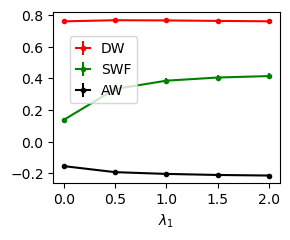

In [87]:
# plot dw, swf, aw relative to lambda1
plot_effect_test(res_l1, ebar=True, bb = (0.4,0.9))

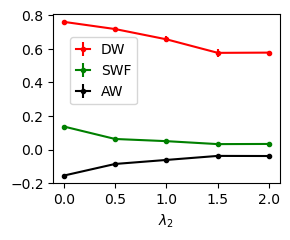

In [88]:
# plot dw, swf, aw relative to lambda2
plot_effect_test(res_l2, content='lambda3',ebar=True,bb=(0.4,0.9))

- The results show that when other hyper parameters are fixed, increasing either $\lambda_1, \lambda_2$ incur expected outcomes



### Separately testing IMP and SF

In this example, it seems that Safety is always gurantted. In this case, we wonder whether improvement is sacrificed if we consider both?

In [65]:
IMP_hp_test = {}
IMP_hp_test['learning_rate'] = 0.1
IMP_hp_test['lambda2'] = np.linspace(0,2,5)
IMP_hp_test['lambda3'] = [0]
IMP_hp_test['n_epochs'] = 10
IMP_hp_test['batch_size'] = 1024
IMP_hp_test['delta_effort'] = 0.5
IMP_hp_test['add_safe'] = False
res_l3 = log_effect_result(data, IMP_hp_test, seed=[0,1,2,3,4,5,6], mode='new')

training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.94epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.22epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.39epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.30epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.50epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.25epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.48epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.04epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.54epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.65epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:01<00:00,  9.48epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:01<00:00,  9.03epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.96epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.52epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.24epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.16epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.97epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.21epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.05epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.75epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.03epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.67epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.74epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.52epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.14epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.51epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.82epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.55epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.31epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.51epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.60epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.64epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.39epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.44epochs/s]

Training finished for all seeds.


In [73]:
def plot_imp(res1, res2, ebar=False, pos = 'best', bb = (0,0)):
    """
    plot the effects of lambda2 or lambda3 only using the testing data
    specifically, the plot consists of: 1) DW; 2) SWF = imp_all + min(imp_a, imp_b); 3) AW = aw_all
    """
    
    plt.figure(figsize = (4,3))

    x = res1['lambda2']
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel('IMP')

    if not ebar:
        plt.plot(x,res1['IMP'], marker = 'o', color = 'blue', label = r'$L_{SWF} = L_{IMP} + L_{SF}$')
        plt.plot(x,res2['IMP'], marker = 's', color = 'red', label = r'$L_{SWF} = L_{IMP}$')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/income_imp.pdf')

    
    else:
        plt.errorbar(x,res1['IMP'], yerr=res1['IMP_var'],marker = 'o', color = 'blue', label = 'IMP')
        plt.errorbar(x,res2['IMP'], yerr=res2['IMP_var'],marker = 's', color = 'red', label = 'SF')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/ebar_income_imp.pdf')


def plot_safe(res1, res2, ebar=False, pos = 'best', bb = (0,0)):
    """
    plot the effects of lambda2 or lambda3 only using the testing data
    specifically, the plot consists of: 1) DW; 2) SWF = imp_all + min(imp_a, imp_b); 3) AW = aw_all
    """
    
    plt.figure(figsize = (4,3))

    x = res1['lambda2']
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel('SF')

    if not ebar:
        plt.plot(x,np.round(res1['SF'],3), marker = 'o', color = 'blue', label = r'$L_{SWF} = L_{IMP} + L_{SF}$')
        plt.plot(x,np.round(res2['SF'],3), marker = 's', color = 'red', label = r'$L_{SWF} = L_{IMP}$',alpha=0.5)
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/income_sf.pdf')

    
    else:
        plt.errorbar(x,np.round(res1['SF'],3), yerr=res1['SF_var'],marker = 'o', color = 'blue', label = 'IMP')
        plt.errorbar(x,np.round(res2['SF'],3), yerr=res2['SF_var'],marker = 's', color = 'red', label = 'SF')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/ebar_income_sf.pdf')

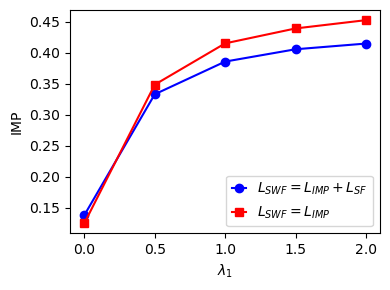

In [74]:
plot_imp(res_l1, res_l3)

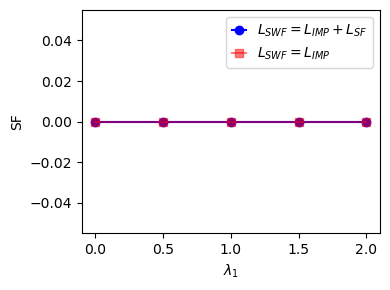

In [75]:
plot_safe(res_l1, res_l3)

### Select the best policy $f$ by summing all welfare up

In [36]:
def log_best_test(dataset, hp_test, seed=[0], mode='new'):
    hp = hp_test.copy()
    result = []
    for i in hp_test['learning_rate']:
        for k in hp_test['lambda2']:
            for j in hp_test['lambda3']:
                c = []
                hp['learning_rate'] = i
                hp['lambda2'] = k
                hp['lambda3'] = j
                train, val, _ = log_model_runner(dataset, hp, seeds=seed, mode=mode)
                c.append(hp['learning_rate'])
                c.append(hp['lambda2'])
                c.append(hp['lambda3'])
                c.append(train['accuracy_mean'])
                c.append(val['accuracy_mean'])
                c.append(val['swf_mean'])
                c.append(val['aw_all_mean'])
                c.append(val['aw_all_mean'] + val['swf_mean'] + val['accuracy_mean'])
                result.append(c)
    print(tabulate(result, headers=['learning_rate', 'lambda2_', 'lambda3_','accuracy_train', 'accuracy_val','swf',
                                    'aw','total_welfare']))

In [67]:
IMP_hp_test = {}
IMP_hp_test['learning_rate'] = [0.1]
IMP_hp_test['lambda2'] = np.linspace(0,2,5)
IMP_hp_test['lambda3'] = np.linspace(0,2,5)
IMP_hp_test['n_epochs'] = 10
IMP_hp_test['batch_size'] = 1024
IMP_hp_test['delta_effort'] = 0.5
IMP_hp_test['add_safe'] = True
log_best_test(data, IMP_hp_test, seed=[0,1,2,3,4,5,6])

training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.44epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.97epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.74epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.99epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.76epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.52epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.66epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.88epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.68epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.85epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.76epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.66epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.87epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.59epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.82epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.86epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.62epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.73epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.67epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.79epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.83epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.48epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.90epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.02epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.99epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.91epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.93epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.10epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.62epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.13epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.10epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.97epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.87epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.74epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.87epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.95epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.84epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.65epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.51epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.71epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.91epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.66epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.72epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.65epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.85epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.52epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.72epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.92epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.79epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.84epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.77epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.65epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.75epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.97epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.84epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.89epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.56epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.65epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.77epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.88epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.90epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.95epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.85epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.68epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.80epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.87epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.89epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.87epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.74epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.32epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.79epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.64epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.85epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.76epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.90epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.18epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.83epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.75epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.74epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.79epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.74epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.89epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.67epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.80epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.55epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.86epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.74epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.96epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.88epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.59epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.00epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.88epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.94epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.03epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.87epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.73epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.63epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.96epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.93epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.89epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.85epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.73epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.82epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.43epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.84epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.81epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.77epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.86epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.62epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.80epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.25epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.77epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.64epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.87epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.71epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.69epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.84epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.65epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.66epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.73epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.80epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.81epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.88epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.94epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.74epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.84epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.82epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.81epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.92epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.81epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.81epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.70epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.87epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.89epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.97epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.81epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.70epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.80epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.43epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.46epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.72epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.87epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.73epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.68epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.64epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.36epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.63epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.72epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.77epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.70epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.71epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.61epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.93epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.68epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.40epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.88epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.72epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.91epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.10epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.95epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.34epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.35epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.82epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.78epochs/s]

Training finished for all seeds.
  learning_rate    lambda2_    lambda3_    accuracy_train    accuracy_val        swf          aw    total_welfare
---------------  ----------  ----------  ----------------  --------------  ---------  ----------  ---------------
            0.1         0           0            0.765781        0.76875   0.137364   -0.155987          0.750128
            0.1         0           0.5          0.719888        0.719732  0.0634553  -0.0870266         0.696161
            0.1         0           1            0.650938        0.65192   0.050359   -0.0628153         0.639463
            0.1         0           1.5          0.56673         0.567366  0.0328811  -0.0386378         0.561609
            0.1         0           2            0.567913        0.567545  0.0338121  -0.0390523         0.562304
            0.1         0.5         0            0.768125        0.770179  0.335748   -0.193986          0.91194
            0.1         0.5         0.5          0.72824

Thus, we finally select learning rate = 0.1, lambda1 = 1.5, lambda2 = 0.5 with total welfare = 0.6926

### Compare with other algos


- StratWelfare: learning rate = 0.1, lambda1 = 1.5, lambda2 = 0.5
- Model = ERM, EI, BE, Safe
- EI, BE, Safe: lambda_ = 0.1 

In [5]:
def experiment_runner(dataset, ERM_hp, IMP_hp, Safe_hp, EI_hp, BE_hp,seeds):
    
    _, _, ERM = log_model_runner(dataset, ERM_hp, seeds, mode='baseline')
    _, _, STWF = log_model_runner(dataset, IMP_hp, seeds, mode='new')
    _, _, EI = log_model_runner(dataset, EI_hp, seeds, mode='baseline')
    _, _, SAFE = log_model_runner(dataset, Safe_hp, seeds, mode='baseline')
    _, _, BE = log_model_runner(dataset, BE_hp, seeds, mode='baseline')
    
    return ERM, STWF, EI, SAFE, BE


Safe_hp = {}
Safe_hp['learning_rate'] = 0.1
Safe_hp['lambda_'] = 0.1
Safe_hp['n_epochs'] = 10
Safe_hp['batch_size'] = 1024
Safe_hp['metric'] = 'SAFE'
Safe_hp['delta_effort'] = 0.5

EI_hp = {}
EI_hp['learning_rate'] = 0.1
EI_hp['lambda_'] = 0.1
EI_hp['n_epochs'] = 10
EI_hp['batch_size'] = 1024
EI_hp['metric'] = 'EI'
EI_hp['delta_effort'] = 0.5

BE_hp = {}
BE_hp['learning_rate'] = 0.1
BE_hp['lambda_'] = 0.1
BE_hp['n_epochs'] = 10
BE_hp['batch_size'] = 1024
BE_hp['metric'] = 'BE'
BE_hp['delta_effort'] = 0.5

ERM_hp = {}
ERM_hp['learning_rate'] = 0.1
ERM_hp['lambda_'] = 0
ERM_hp['n_epochs'] = 10
ERM_hp['batch_size'] = 1024
ERM_hp['metric'] = 'ERM'
ERM_hp['delta_effort'] = 0.5

IMP_hp = {}
IMP_hp['learning_rate'] = 0.1
IMP_hp['lambda2'] = 1.5
IMP_hp['lambda3'] = 0
IMP_hp['n_epochs'] = 10
IMP_hp['batch_size'] = 1024
IMP_hp['metric'] = 'IMP'
IMP_hp['delta_effort'] = 0.5
IMP_hp['add_safe'] = True

ERM, STWF, EI, SAFE, BE = experiment_runner(data, ERM_hp, IMP_hp, Safe_hp, EI_hp, BE_hp, range(20))

training seed 0 started


Training:   0%|          | 0/10 [00:00<?, ?epochs/s]/Users/tianxie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tianxie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Training: 100%|██████████| 10/10 [00:00<00:00, 11.40epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.14epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.61epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.72epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.64epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.53epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.93epochs/s]


training seed 7 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.31epochs/s]


training seed 8 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.09epochs/s]


training seed 9 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.29epochs/s]


training seed 10 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.12epochs/s]


training seed 11 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.75epochs/s]


training seed 12 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.28epochs/s]


training seed 13 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.38epochs/s]


training seed 14 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.74epochs/s]


training seed 15 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.39epochs/s]


training seed 16 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.35epochs/s]


training seed 17 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.37epochs/s]


training seed 18 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.60epochs/s]


training seed 19 started


Training: 100%|██████████| 10/10 [00:00<00:00, 13.69epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.77epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.17epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.52epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.13epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.42epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.94epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.16epochs/s]


training seed 7 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.15epochs/s]


training seed 8 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.95epochs/s]


training seed 9 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.04epochs/s]


training seed 10 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.51epochs/s]


training seed 11 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.98epochs/s]


training seed 12 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.17epochs/s]


training seed 13 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.08epochs/s]


training seed 14 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.09epochs/s]


training seed 15 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.06epochs/s]


training seed 16 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.02epochs/s]


training seed 17 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.92epochs/s]


training seed 18 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.44epochs/s]


training seed 19 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.61epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.08epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.39epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.29epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.25epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.24epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.13epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.41epochs/s]


training seed 7 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.98epochs/s]


training seed 8 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.31epochs/s]


training seed 9 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.37epochs/s]


training seed 10 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.20epochs/s]


training seed 11 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.04epochs/s]


training seed 12 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.87epochs/s]


training seed 13 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.79epochs/s]


training seed 14 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.09epochs/s]


training seed 15 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.66epochs/s]


training seed 16 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.62epochs/s]


training seed 17 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.81epochs/s]


training seed 18 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.75epochs/s]


training seed 19 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.76epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.87epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.05epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.22epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:01<00:00,  9.80epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.72epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.87epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.11epochs/s]


training seed 7 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.42epochs/s]


training seed 8 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.50epochs/s]


training seed 9 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.39epochs/s]


training seed 10 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.40epochs/s]


training seed 11 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.42epochs/s]


training seed 12 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.24epochs/s]


training seed 13 started


Training: 100%|██████████| 10/10 [00:01<00:00,  9.91epochs/s]


training seed 14 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.50epochs/s]


training seed 15 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.72epochs/s]


training seed 16 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.17epochs/s]


training seed 17 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.97epochs/s]


training seed 18 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.37epochs/s]


training seed 19 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.06epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.52epochs/s]


training seed 1 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.63epochs/s]


training seed 2 started


Training: 100%|██████████| 10/10 [00:00<00:00, 10.92epochs/s]


training seed 3 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.64epochs/s]


training seed 4 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.09epochs/s]


training seed 5 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.17epochs/s]


training seed 6 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.18epochs/s]


training seed 7 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.45epochs/s]


training seed 8 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.21epochs/s]


training seed 9 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.69epochs/s]


training seed 10 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.21epochs/s]


training seed 11 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.77epochs/s]


training seed 12 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.43epochs/s]


training seed 13 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.39epochs/s]


training seed 14 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.01epochs/s]


training seed 15 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.14epochs/s]


training seed 16 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.29epochs/s]


training seed 17 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.45epochs/s]


training seed 18 started


Training: 100%|██████████| 10/10 [00:00<00:00, 11.94epochs/s]


training seed 19 started


Training: 100%|██████████| 10/10 [00:00<00:00, 12.47epochs/s]

Training finished for all seeds.


In [6]:
result = []
models = ["ERM", "STWF",  "SAFE", "EI", "BE"]
sol = [ERM, STWF, EI, SAFE, BE]
for i in range(len(models)):
    c = []
    c.append(models[i])
    res = sol[i]
    c.append(res['accuracy_mean'])
    c.append(res['accuracy_var'])
    c.append(res['swf_mean'])
    c.append(res['swf_var']) 
    c.append(res['safety_mean'])
    c.append(res['safety_var']) 
    c.append(res['aw_all_mean'])
    c.append(res['aw_all_var'])
    c.append(res['ei_mean'])
    c.append(res['ei_var'])
    c.append(res['be_mean'])
    c.append(res['be_var'])
    c.append(res['dp_mean'])
    c.append(res['dp_var'])
    c.append(res['eo_mean'])
    c.append(res['eo_var'])
    c.append(res['eodd_mean'])
    c.append(res['eodd_var'])
    result.append(c)

print(tabulate(result, headers=["model","accuracy_mean","accuracy_var","swf_mean","swf_var","safety_mean","safety_var","aw_all_mean","aw_all_var",
                                "ei_mean","ei_var","be_mean","be_var", "dp_mean", "dp_var","eo_mean","eo_var","eodd_mean","eodd_var"]))

model      accuracy_mean    accuracy_var    swf_mean     swf_var    safety_mean    safety_var    aw_all_mean    aw_all_var     ei_mean      ei_var    be_mean      be_var    dp_mean      dp_var    eo_mean      eo_var    eodd_mean    eodd_var
-------  ---------------  --------------  ----------  ----------  -------------  ------------  -------------  ------------  ----------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  -----------  ----------
ERM             0.764938      0.00265268    0.125848  0.00287134              0             0      -0.155319   1.18567e-05  0.0115391   0.00447178  0.0411451  0.00389706  0.104147   0.00538291  0.0971539  0.0115708     0.0971539  0.0115708
STWF            0.767213      0.00125567    0.403988  0.0110951               0             0      -0.210483   1.03491e-05  0.00356286  0.0019926   0.0744302  0.00563641  0.0767026  0.00523787  0.0508648  0.00774298    0.0510564  0.00744562
SAFE            0.764637      0.00224

In [7]:
# process the results into dataframe
dict_res = {}
headers=["model","accuracy_mean","accuracy_var","swf_mean","swf_var","safety_mean","safety_var","aw_all_mean","aw_all_var",
                                "ei_mean","ei_var","be_mean","be_var", "dp_mean", "dp_var","eo_mean","eo_var","eodd_mean","eodd_var"]
for item in result:
    i = 1
    dict_res[item[0]] = {}
    for head in headers[1:]:
        dict_res[item[0]][head] = item[i]
        i += 1

# save the results
with open('saved_texts/comparison_ACS.txt', 'w') as file:
    for row in result:
        # Convert each item in the list to a string and join with a space (or any other delimiter)
        file.write(' '.join(map(str, row)) + '\n')

In [7]:
# read the result as a dictionary
models = ["ERM", "STWF",  "SAFE", "EI", "BE"]
dict_res = {}
headers=["model","accuracy_mean","accuracy_var","swf_mean","swf_var","safety_mean","safety_var","aw_all_mean","aw_all_var",
                                "ei_mean","ei_var","be_mean","be_var", "dp_mean", "dp_var","eo_mean","eo_var","eodd_mean","eodd_var"]
with open('saved_texts/comparison_ACS.txt', 'r') as file:
    for line in file:
        row = line.split()
        i = 1
        dict_res[row[0]] = {}
        for head in headers[1:]:
            dict_res[row[0]][head] = float(row[i])
            i += 1

dict_res

{'ERM': {'accuracy_mean': 0.7649375,
  'accuracy_var': 0.002652681426406118,
  'swf_mean': 0.12584838271141052,
  'swf_var': 0.00287133501842618,
  'safety_mean': 0.0,
  'safety_var': 0.0,
  'aw_all_mean': -0.15531942856982348,
  'aw_all_var': 1.1856667847569906e-05,
  'ei_mean': 0.011539060270514184,
  'ei_var': 0.0044717782576255815,
  'be_mean': 0.04114506892895016,
  'be_var': 0.0038970555811001775,
  'dp_mean': 0.10414656680805938,
  'dp_var': 0.0053829087035172606,
  'eo_mean': 0.09715393195761295,
  'eo_var': 0.01157081292143449,
  'eodd_mean': 0.09715393195761295,
  'eodd_var': 0.01157081292143449},
 'STWF': {'accuracy_mean': 0.7672125000000001,
  'accuracy_var': 0.0012556746194775097,
  'swf_mean': 0.4039883017539978,
  'swf_var': 0.011095085181295872,
  'safety_mean': 0.0,
  'safety_var': 0.0,
  'aw_all_mean': -0.21048347967080772,
  'aw_all_var': 1.0349114609020911e-05,
  'ei_mean': 0.0035628627248936286,
  'ei_var': 0.001992599241390103,
  'be_mean': 0.07443016967126195,
  

Plot the relationship between welfares

In [9]:
def plot_welfare_comparison(dict_res, ebar=False):
    welfare =  {'name':models,'DW':[],'DW_var':[], 'AW':[],'AW_var':[], 'SWF':[],'SWF_var':[],'TOTAL':[],'TOTAL_var':[]}
    plt.figure(figsize = (4,3))
    plt.xlabel('model')
    plt.ylabel('welfare')
    # Setting the positions and width for the bars
    barWidth = 0.18
    r1 = np.arange(len(models))  # positions for the first set of bars
    r2 = [x + barWidth for x in r1]  # positions for the second set of bars
    r3 = [x + barWidth for x in r2] # positions for the third set of bars
    r4 = [x + barWidth for x in r3]

    for name in models:
        welfare['DW'].append(dict_res[name]['accuracy_mean'])
        welfare['DW_var'].append(dict_res[name]['accuracy_var'])
        welfare['SWF'].append(dict_res[name]['swf_mean'])
        welfare['SWF_var'].append(dict_res[name]['swf_var'])
        welfare['AW'].append(dict_res[name]['aw_all_mean'])
        welfare['AW_var'].append(dict_res[name]['aw_all_var'])
        welfare['TOTAL'].append(dict_res[name]['aw_all_mean'] + dict_res[name]['accuracy_mean'] + dict_res[name]['swf_mean'])
        welfare['TOTAL_var'].append(dict_res[name]['aw_all_var'] + dict_res[name]['accuracy_var'] + dict_res[name]['swf_var'])

    if not ebar:
        plt.bar(r1, welfare['DW'], width=barWidth, label = 'DW',color = 'blue')
        plt.bar(r2, welfare['SWF'], width=barWidth,label = 'SWF',color = 'orange')
        plt.bar(r3, welfare['AW'], width=barWidth,label = 'AW', color = 'green')
        plt.bar(r4, welfare['TOTAL'], width=barWidth,label = 'TOTAL', color = 'red')

    else:
        plt.bar(r1, welfare['DW'], yerr = welfare['DW_var'],width=barWidth,label = 'DW',color = 'blue')
        plt.bar(r2, welfare['SWF'], yerr = welfare['SWF_var'],width=barWidth,label = 'SWF',color = 'orange')
        plt.bar(r3, welfare['AW'], yerr = welfare['AW_var'],width=barWidth,label = 'AW',color = 'green')
        plt.bar(r4, welfare['TOTAL'], yerr = welfare['TOTAL_var'], width=barWidth,label = 'TOTAL', color = 'red')
    
    plt.xticks([r + barWidth for r in range(len(models))], models)

    
    plt.legend(handlelength = 0.5)
    plt.tight_layout()
    if not ebar:
        plt.savefig('saved_plots/income_welfare_comp.pdf')
    else:
        plt.savefig('saved_plots/ebar_income_welfare_comp.pdf')

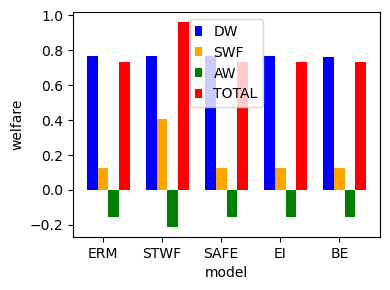

In [10]:
plot_welfare_comparison(dict_res, ebar=False)

Plot the relationship between fairness

In [13]:
def plot_long_fairness_comparison(dict_res, ebar=False):
    welfare =  {'name':models,'EI':[],'EI_var':[], 'BE':[],'BE_var':[], 'DP':[],'DP_var':[], 'EO':[], 'EO_var':[], 'EODD':[], 'EODD_var':[]}
    plt.figure(figsize = (4,3))
    plt.xlabel('model')
    plt.ylabel('unfairness')
    # Setting the positions and width for the bars
    barWidth = 0.16
    r1 = np.arange(len(models))  # positions for the first set of bars
    r2 = [x + barWidth for x in r1]  # positions for the second set of bars

    for name in models:
        welfare['EI'].append(dict_res[name]['ei_mean'])
        welfare['EI_var'].append(dict_res[name]['ei_var'])
        welfare['BE'].append(dict_res[name]['be_mean'])
        welfare['BE_var'].append(dict_res[name]['be_var'])
        welfare['DP'].append(dict_res[name]['dp_mean'])
        welfare['DP_var'].append(dict_res[name]['dp_var'])
        welfare['EO'].append(dict_res[name]['eo_mean'])
        welfare['EO_var'].append(dict_res[name]['eo_var'])
        welfare['EODD'].append(dict_res[name]['eodd_mean'])
        welfare['EODD_var'].append(dict_res[name]['eodd_var'])

    if not ebar:
        plt.bar(r1, welfare['EI'], width=barWidth, label = 'EI fairness',color = 'blue')
        plt.bar(r2, welfare['BE'], width=barWidth,label = 'BE fairness',color = 'red')

    else:
        plt.bar(r1, welfare['EI'], yerr = welfare['EI_var'], width=barWidth, label = 'EI fairness',color = 'blue')
        plt.bar(r2, welfare['BE'],  yerr = welfare['BE_var'], width=barWidth,label = 'BE fairness',color = 'red')
    
    plt.xticks([r + barWidth for r in range(len(models))], models)
    plt.yticks(np.arange(0, 0.1, step=0.01))

    
    plt.legend(handlelength = 0.5)
    plt.tight_layout()
    if not ebar:
        plt.savefig('saved_plots/income_long_fairness_comp.pdf')
    else:
        plt.savefig('saved_plots/ebar_income_long_fairness_comp.pdf')




def plot_instant_fairness_comparison(dict_res, ebar=False):
    welfare =  {'name':models,'EI':[],'EI_var':[], 'BE':[],'BE_var':[], 'DP':[],'DP_var':[], 'EO':[], 'EO_var':[], 'EODD':[], 'EODD_var':[]}
    plt.figure(figsize = (4,3))
    plt.xlabel('model')
    plt.ylabel('unfairness')
    # Setting the positions and width for the bars
    barWidth = 0.16
    r1 = np.arange(len(models))  # positions for the first set of bars
    r2 = [x + barWidth for x in r1]  # positions for the second set of bars
    r3 = [x + barWidth for x in r2] # positions for the third set of bars

    for name in models:
        welfare['EI'].append(dict_res[name]['ei_mean'])
        welfare['EI_var'].append(dict_res[name]['ei_var'])
        welfare['BE'].append(dict_res[name]['be_mean'])
        welfare['BE_var'].append(dict_res[name]['be_var'])
        welfare['DP'].append(dict_res[name]['dp_mean'])
        welfare['DP_var'].append(dict_res[name]['dp_var'])
        welfare['EO'].append(dict_res[name]['eo_mean'])
        welfare['EO_var'].append(dict_res[name]['eo_var'])
        welfare['EODD'].append(dict_res[name]['eodd_mean'])
        welfare['EODD_var'].append(dict_res[name]['eodd_var'])

    if not ebar:
        plt.bar(r1, welfare['DP'], width=barWidth, label = 'DP fairness',color = 'blue')
        plt.bar(r2, welfare['EO'], width=barWidth,label = 'EO fairness',color = 'red')

    else:
        plt.bar(r1, welfare['DP'], yerr = welfare['DP_var'],width=barWidth,label = 'DP fairness', color = 'red')
        plt.bar(r2, welfare['EO'],  yerr = welfare['EO_var'],width=barWidth,label = 'EO fairness',color = 'blue')
    
    plt.xticks([r + barWidth for r in range(len(models))], models)

    
    plt.legend(handlelength = 0.5)
    plt.tight_layout()
    if not ebar:
        plt.savefig('saved_plots/income_instant_fairness_comp.pdf')
    else:
        plt.savefig('saved_plots/ebar_income_instant_fairness_comp.pdf')

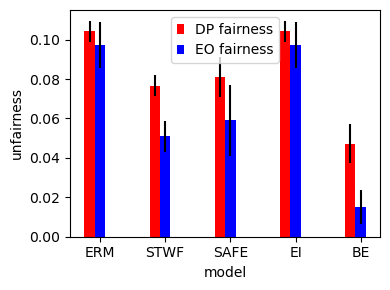

In [14]:
plot_instant_fairness_comparison(dict_res,ebar=True)

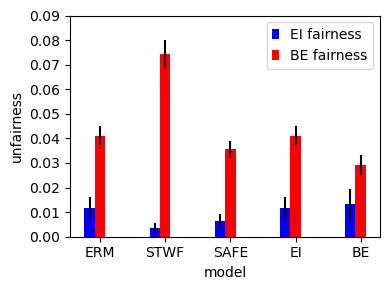

In [14]:
plot_long_fairness_comparison(dict_res,ebar=True)